
# Using MC Dropout, Deep Ensembles, and Temperature Scaling on california Housing Dataset

In [3]:
# Import necessary libraries: tensorflow for models, sklearn for dataset and metrics, pandas/numpy for data, matplotlib/seaborn for plots
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [4]:
# Load California Housing dataset from sklearn, convert to DataFrame, split into features (X) and target (y), then train-test split (80/20), standardize features
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train into train/val (80/20 of train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Import the build_mlp function from models/simple_mlp.py
from models.simple_mlp import build_mlp

Epoch 1/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2189 - val_loss: 0.5653
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5868 - val_loss: 0.4330
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5006 - val_loss: 0.4043
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4657 - val_loss: 0.3942
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4451 - val_loss: 0.3752
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4361 - val_loss: 0.3683
Epoch 7/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4154 - val_loss: 0.3672
Epoch 8/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4196 - val_loss: 0.3549
Epoch 9/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3978 - val_loss: 0.3547
Epoch 10/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3854 - val_loss: 0.3448
Epoch 11/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3821 - val_loss: 0.3460
Epoch 12/100
331/331 ━━━━━━━━━━━━━━━━━━━━

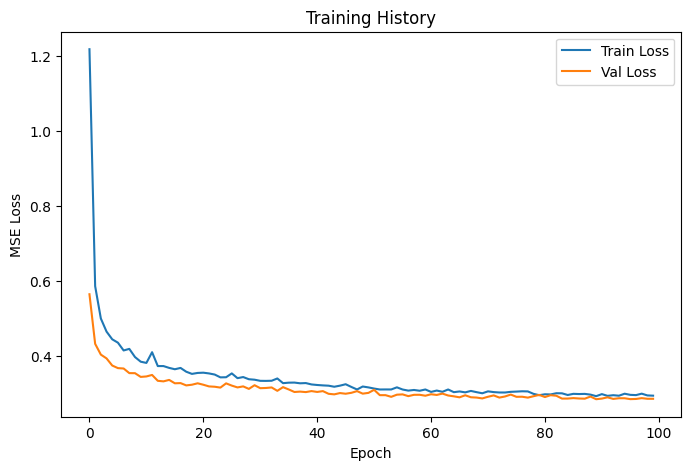

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
Test MSE: 0.2900, RMSE: 0.5386, R2: 0.7787


In [6]:
# Build the MLP model with input shape from X_train
mlp_model = build_mlp(X_train_scaled.shape[1])

# Train on X_train_scaled, y_train for 100 epochs, batch_size=32, validation_split=0.2
history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history (loss and val_loss)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.show()

# Evaluate on test set
predictions = mlp_model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

In [7]:
# Import mc_dropout_predict from methods/mc_dropout.py
from methods.mc_dropout import mc_dropout_predict

# Get MC Dropout predictions on X_test
means_mc, stds_mc = mc_dropout_predict(mlp_model, X_test_scaled, n_samples=30)

# Compute metrics: MSE between means and y_test, average interval width (1.96 * stds)
mse_mc = mean_squared_error(y_test, means_mc)
avg_interval_width_mc = 2 * 1.96 * np.mean(stds_mc)
print(f"MC Dropout Test MSE: {mse_mc:.4f}")
print(f"MC Dropout Avg. 95% Interval Width: {avg_interval_width_mc:.4f}")

MC Dropout Test MSE: 0.2915
MC Dropout Avg. 95% Interval Width: 0.5795


In [8]:
# Import train_ensemble and ensemble_predict from methods/deep_ensemble.py
from methods.deep_ensemble import train_ensemble, ensemble_predict
import time

# Train ensemble on X_train_scaled, y_train
start_time = time.time()
ensemble_models = train_ensemble(X_train_scaled, y_train, k=5, epochs=100)
train_time = time.time() - start_time
print(f"Ensemble training time: {train_time:.2f} seconds")

# Get ensemble means and stds on X_test
means_ens, stds_ens = ensemble_predict(ensemble_models, X_test_scaled)

# Compute metrics: MSE between means and y_test, average interval width (1.96 * stds)
mse_ens = mean_squared_error(y_test, means_ens)
avg_interval_width_ens = 2 * 1.96 * np.mean(stds_ens)
print(f"Ensemble Test MSE: {mse_ens:.4f}")
print(f"Ensemble Avg. 95% Interval Width: {avg_interval_width_ens:.4f}")

Ensemble training time: 299.89 seconds
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ensemble Test MSE: 0.2823
Ensemble Avg. 95% Interval Width: 0.4095
Ensemble Test MSE: 0.2823
Ensemble Avg. 95% Interval Width: 0.4095


In [9]:
# Import temperature_scale from methods/temp_scaling.py
from methods.temp_scaling import temperature_scale

# MC Dropout: get means/stds on validation set
means_mc_val, stds_mc_val = mc_dropout_predict(mlp_model, X_val_scaled, n_samples=30)
vars_mc_val = stds_mc_val ** 2

# Find optimal temperature T for MC Dropout
T_mc = temperature_scale(means_mc_val, vars_mc_val, y_val)
print(f"Optimal temperature (MC Dropout): {T_mc:.4f}")

# Apply temperature scaling to test stds
scaled_stds_mc = stds_mc / np.sqrt(T_mc)

# Compute coverage: fraction of test points where |y - mean| < 1.96 * scaled_std
coverage_mc = np.mean(np.abs(y_test - means_mc) < 1.96 * scaled_stds_mc)
print(f"MC Dropout 95% interval coverage after scaling: {coverage_mc:.3f}")

# Repeat for Ensemble
means_ens_val, stds_ens_val = ensemble_predict(ensemble_models, X_val_scaled)
vars_ens_val = stds_ens_val ** 2
T_ens = temperature_scale(means_ens_val, vars_ens_val, y_val)
print(f"Optimal temperature (Ensemble): {T_ens:.4f}")
scaled_stds_ens = stds_ens / np.sqrt(T_ens)
coverage_ens = np.mean(np.abs(y_test - means_ens) < 1.96 * scaled_stds_ens)
print(f"Ensemble 95% interval coverage after scaling: {coverage_ens:.3f}")

Optimal temperature (MC Dropout): 0.0700
MC Dropout 95% interval coverage after scaling: 0.944
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Optimal temperature (Ensemble): 0.0258
Ensemble 95% interval coverage after scaling: 0.955


In [11]:
# Function to compute MSE, RMSE, R2 given y_true and y_pred
def compute_accuracy_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Compute Prediction Interval Coverage Probability (PICP) and Mean Prediction Interval Width (MPIW)
def compute_uncertainty_metrics(y_true, means, stds, confidence=0.95):
    z = 1.96 if confidence == 0.95 else norm.ppf(0.5 + confidence/2)
    lower = means - z * stds
    upper = means + z * stds
    picp = np.mean((y_true >= lower) & (y_true <= upper))
    mpiw = np.mean(upper - lower)
    return picp, mpiw

# MC Dropout metrics
mse_mc, rmse_mc, r2_mc = compute_accuracy_metrics(y_test, means_mc)
picp_mc, mpiw_mc = compute_uncertainty_metrics(y_test, means_mc, scaled_stds_mc)

# Ensemble metrics
mse_ens, rmse_ens, r2_ens = compute_accuracy_metrics(y_test, means_ens)
picp_ens, mpiw_ens = compute_uncertainty_metrics(y_test, means_ens, scaled_stds_ens)

# Display results in a DataFrame
import pandas as pd
results_df = pd.DataFrame({
    'Method': ['MC Dropout', 'Deep Ensemble'],
    'MSE': [mse_mc, mse_ens],
    'RMSE': [rmse_mc, rmse_ens],
    'R2': [r2_mc, r2_ens],
    'PICP': [picp_mc, picp_ens],
    'MPIW': [mpiw_mc, mpiw_ens]
})
display(results_df)

,Method,MSE,RMSE,R2,PICP,MPIW
0,MC Dropout,0.291539,0.539944,0.777520,0.944041,2.190101
1,Deep Ensemble,0.282339,0.531355,0.784542,0.955184,2.549699


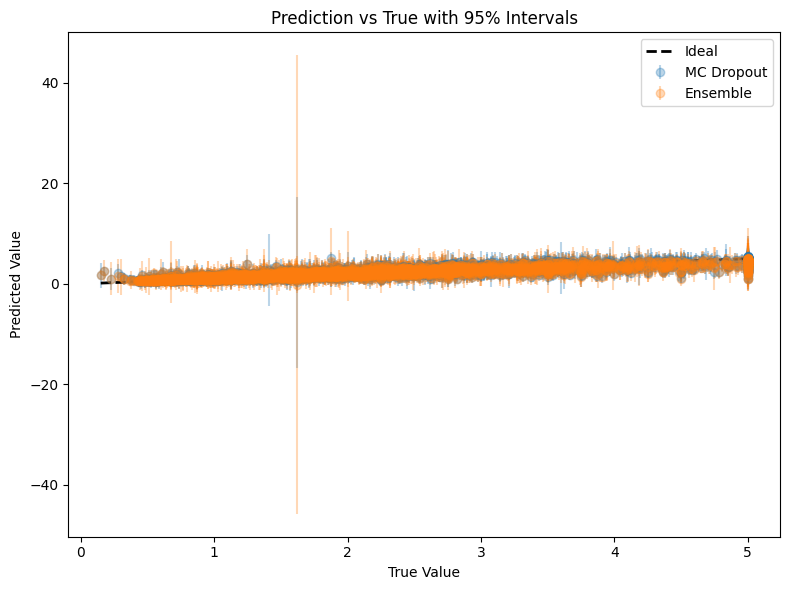

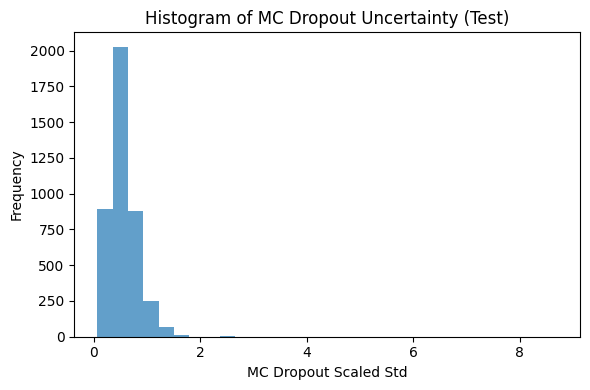

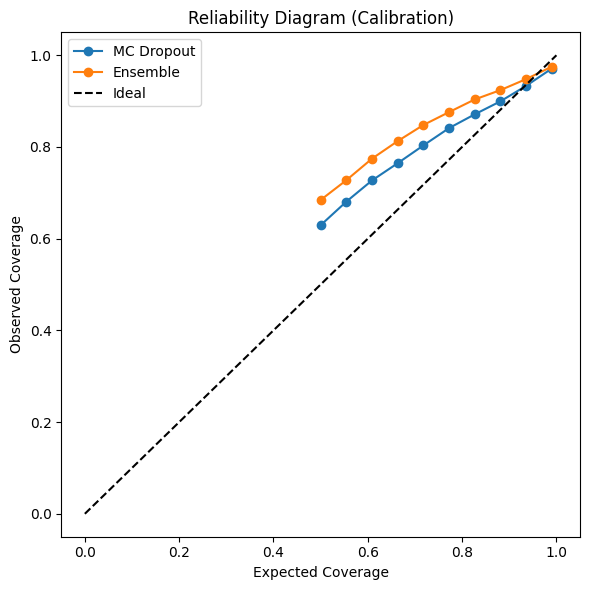

In [12]:
# Scatter plot: y_test vs means, with error bars ±1.96*stds for each method
plt.figure(figsize=(8,6))
plt.errorbar(y_test, means_mc, yerr=1.96*scaled_stds_mc, fmt='o', alpha=0.3, label='MC Dropout')
plt.errorbar(y_test, means_ens, yerr=1.96*scaled_stds_ens, fmt='o', alpha=0.3, label='Ensemble')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Prediction vs True with 95% Intervals')
plt.legend()
plt.tight_layout()
plt.savefig('results/prediction_vs_true.png')
plt.show()

# Histogram of stds for MC Dropout
plt.figure(figsize=(6,4))
plt.hist(scaled_stds_mc, bins=30, alpha=0.7)
plt.xlabel('MC Dropout Scaled Std')
plt.ylabel('Frequency')
plt.title('Histogram of MC Dropout Uncertainty (Test)')
plt.tight_layout()
plt.savefig('results/uncertainty_hist.png')
plt.show()

# Reliability diagram: expected vs actual coverage for intervals at different levels
def reliability_diagram(y_true, means, stds, method_name):
    coverages = np.linspace(0.5, 0.99, 10)
    observed = []
    for c in coverages:
        z = norm.ppf(0.5 + c/2)
        lower = means - z * stds
        upper = means + z * stds
        obs = np.mean((y_true >= lower) & (y_true <= upper))
        observed.append(obs)
    plt.plot(coverages, observed, 'o-', label=method_name)

plt.figure(figsize=(6,6))
reliability_diagram(y_test, means_mc, scaled_stds_mc, 'MC Dropout')
reliability_diagram(y_test, means_ens, scaled_stds_ens, 'Ensemble')
plt.plot([0,1],[0,1],'k--',label='Ideal')
plt.xlabel('Expected Coverage')
plt.ylabel('Observed Coverage')
plt.title('Reliability Diagram (Calibration)')
plt.legend()
plt.tight_layout()
plt.savefig('results/calibration_plot.png')
plt.show()

In [13]:
# Measure and print training/inference time for each method
import time

# Timing MC Dropout inference
start = time.time()
_ = mc_dropout_predict(mlp_model, X_test_scaled, n_samples=30)
time_mc_infer = time.time() - start
print(f"MC Dropout inference time (30 samples): {time_mc_infer:.2f} seconds")

# Timing Ensemble inference
start = time.time()
_ = ensemble_predict(ensemble_models, X_test_scaled)
time_ens_infer = time.time() - start
print(f"Ensemble inference time: {time_ens_infer:.2f} seconds")

# Add times to results table
results_df['Train Time (s)'] = [None, train_time]  # Only ensemble train time measured
results_df['Infer Time (s)'] = [time_mc_infer, time_ens_infer]
display(results_df)

# Markdown cell for discussion
from IPython.display import Markdown, display as md_display
md_display(Markdown('''
### Computational Cost Analysis
- **MC Dropout**: Training time is similar to a single model, but inference is slower because it requires multiple stochastic forward passes (here, 30).
- **Deep Ensemble**: Training time is higher (training 5 models), but inference is fast (just 5 forward passes).
- **Trade-off**: MC Dropout is more efficient for training, but slower for inference. Ensembles are more expensive to train, but can be faster at inference for a small number of models.
'''))

MC Dropout inference time (30 samples): 0.22 seconds
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
Ensemble inference time: 0.95 seconds
Ensemble inference time: 0.95 seconds


,Method,MSE,RMSE,R2,PICP,MPIW,Train Time (s),Infer Time (s)
0,MC Dropout,0.291539,0.539944,0.777520,0.944041,2.190101,NaN,0.221527
1,Deep Ensemble,0.282339,0.531355,0.784542,0.955184,2.549699,299.892219,0.948418



### Computational Cost Analysis
- **MC Dropout**: Training time is similar to a single model, but inference is slower because it requires multiple stochastic forward passes (here, 30).
- **Deep Ensemble**: Training time is higher (training 5 models), but inference is fast (just 5 forward passes).
- **Trade-off**: MC Dropout is more efficient for training, but slower for inference. Ensembles are more expensive to train, but can be faster at inference for a small number of models.
